In [1]:
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')
import pandas as pd
import dask.dataframe as dd

In [2]:
from dmagellan.blocker.overlap.overlapblocker_ddf import OverlapBlocker

In [29]:
from dmagellan.feature.extractfeatures import extract_feature_vecs
from dmagellan.feature.autofeaturegen import get_features_for_matching
from dask import delayed
from dask.threaded import get
from distributed import Client
import py_entitymatching as em
from dmagellan.matcher.dtmatcher import DTMatcher


In [4]:
orig_A = dd.read_csv('../data/citeseer_nonans.csv', usecols=['id', 'title'], blocksize=64000000 )
orig_B = dd.read_csv('../data/dblp_nonans.csv', usecols=['id', 'title'], blocksize=64000000)

In [5]:
orig_A.npartitions, orig_B.npartitions

(4, 5)

In [6]:
client = Client('127.0.0.1:8786')

In [7]:
# sample datasets
A = dd.read_csv('../data/sample_citeseer.csv', usecols=['id', 'title'])
B = dd.read_csv('../data/sample_dblp.csv', usecols=['id', 'title'])

In [8]:
# blocking
ob = OverlapBlocker()
C = ob.block_tables(A, B, 'id', 'id', 'title', 'title', 
                    overlap_size=6, nltable_chunks=A.npartitions, # Note this
                    nrtable_chunks=B.npartitions,
                    
                    scheduler=get, compute=False, 
                    rem_stop_words=True
                   )
# len(C)

In [10]:
D = C.compute(get=client.get)

In [11]:
D.head()

,_id,l_id,r_id
0,0,1204705,1963198
1,1,1009479,1849057
2,2,766548,1390421
3,3,766548,1222504
4,4,1595508,1222504


In [24]:
L = pd.read_csv('../data/sample_labeled_data.csv')


In [14]:
F = em.get_features_for_matching(A.compute(), B.compute())

In [35]:
# Convert L into feature vectors using updated F
H = extract_feature_vecs(L, orig_A, orig_B, 
                         '_id', 'l_id', 'r_id', 'id', 'id', 
                          feature_table=F, 
                          attrs_after='label', nchunks=4,
                          show_progress=True, compute=True, 
                         scheduler=client.get)

In [44]:
# Instantiate the matcher to evaluate.
dt = DTMatcher(name='DecisionTree', random_state=0)

In [45]:
dt.fit(table=H, 
       exclude_attrs=['_id', 'l_id', 'r_id', 'label'], 
       target_attr='label')

In [38]:
# Convert J into a set of feature vectors using F
I = extract_feature_vecs(C, A, B,
                         '_id', 'l_id', 'r_id', 'id', 'id', 
                            nchunks=4,
                            feature_table=F,
                            
                            show_progress=False,
                            compute=False)

In [46]:
predictions = dt.predict(table=I, exclude_attrs=['_id', 'l_id', 'r_id'], 
              append=True, target_attr='predicted', inplace=False,
                        nchunks=4, scheduler=client.get, compute=False, show_progress=True)

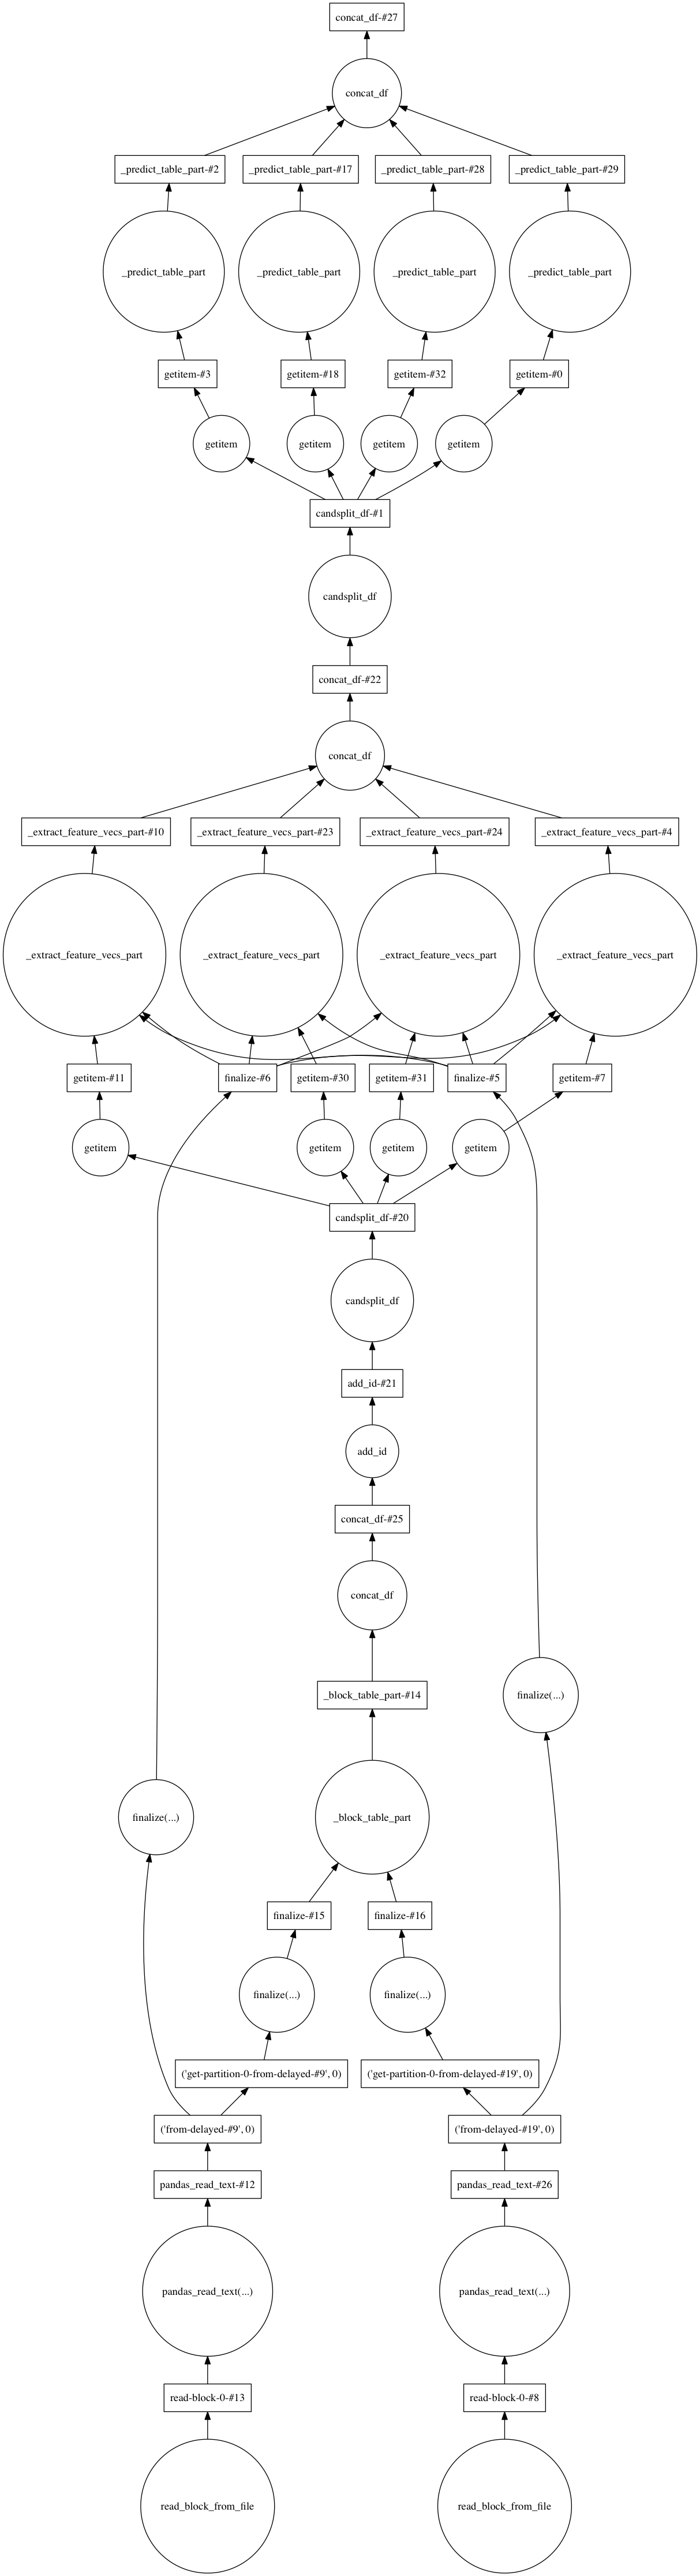

In [48]:
predictions.visualize()

In [47]:
p = predictions.compute()